In [1]:
import torch
from torch import ones, zeros, eye, float32, as_tensor, tensor
from torch.distributions import MultivariateNormal
from torch.optim import Adam

from sbi.utils import BoxUniform
from sbi.analysis import pairplot

In [9]:
prior = BoxUniform(-3*ones((2,)), 3*ones((2,)))
theta = prior.sample((1000,))
x = theta + torch.randn_like(theta) * 0.1
x_o = tensor([1.0, 1.0])

### SNPE (amortized, single-round)

In [22]:
from sbi.neural_nets.flow import build_nsf
from sbi.neural_nets.density_estimators.flow import NFlowsFlow
from sbi.inference.posteriors import DirectPosterior

In [23]:
net = build_nsf(theta, x)
de = NFlowsFlow(net, condition_shape=(x.shape[1],))

In [28]:
opt = Adam(list(de.parameters()), lr=5e-4)

for _ in range(100):
    opt.zero_grad()
    log_probs = de.log_prob(theta, condition=x)
    loss = -torch.mean(log_probs)
    loss.backward()
    opt.step()

In [29]:
posterior = DirectPosterior(de.net, prior)

In [30]:
samples = posterior.sample((1000,), x=x_o)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

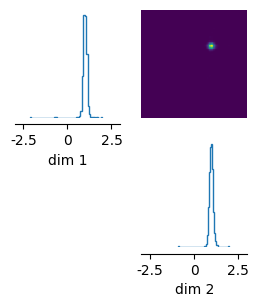

In [31]:
_ = pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3))

### SNLE (amortized, single-round)

In [32]:
from sbi.neural_nets.flow import build_nsf
from sbi.neural_nets.density_estimators.flow import NFlowsFlow
from sbi.inference.posteriors import MCMCPosterior
from sbi.inference.potentials import likelihood_estimator_based_potential

In [33]:
net = build_nsf(x, theta)
de = NFlowsFlow(net, condition_shape=(theta.shape[1],))

In [34]:
opt = Adam(list(de.parameters()), lr=5e-4)

for _ in range(100):
    opt.zero_grad()
    log_probs = de.log_prob(x, condition=theta)
    loss = -torch.mean(log_probs)
    loss.backward()
    opt.step()

In [35]:
potential, tf = likelihood_estimator_based_potential(de.net, prior, x_o)
posterior = MCMCPosterior(
    potential,
    proposal=prior,
    theta_transform=tf,
    num_chains=100,
    method="slice_np_vectorized"
)

In [36]:
samples = posterior.sample((1000,), x=x_o)
_ = pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3))

Running vectorized MCMC with 100 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

### SNRE (amortized, single-round)

In [48]:
from sbi.neural_nets.classifier import build_resnet_classifier
from sbi.inference.posteriors import MCMCPosterior
from sbi.inference.potentials import ratio_estimator_based_potential
from sbi import utils as utils

In [49]:
net = build_resnet_classifier(x, theta)

In [53]:
opt = Adam(list(net.parameters()), lr=5e-4)

def classifier_logits(net, theta, x, num_atoms):
    batch_size = theta.shape[0]
    repeated_x = utils.repeat_rows(x, num_atoms)
    probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)
    choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)
    contrasting_theta = theta[choices]
    atomic_theta = torch.cat((theta[:, None, :], contrasting_theta), dim=1).reshape(
        batch_size * num_atoms, -1
    )
    return net([atomic_theta, repeated_x])


num_atoms = 10
for _ in range(300):
    opt.zero_grad()
    batch_size = theta.shape[0]
    logits = classifier_logits(net, theta, x, num_atoms=num_atoms)
    logits = logits.reshape(batch_size, num_atoms)
    log_probs = logits[:, 0] - torch.logsumexp(logits, dim=-1)
    loss = -torch.mean(log_probs)
    loss.backward()
    opt.step()

In [54]:
potential, tf = ratio_estimator_based_potential(net, prior, x_o)
posterior = MCMCPosterior(
    potential,
    proposal=prior,
    theta_transform=tf,
    num_chains=100,
    method="slice_np_vectorized"
)

Running vectorized MCMC with 100 chains:   0%|          | 0/20000 [00:00<?, ?it/s]

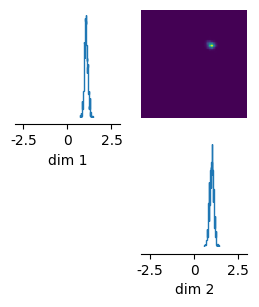

In [55]:
samples = posterior.sample((1000,), x=x_o)
_ = pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3))